## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
import os
os.environ['JAX_PLATFORM_NAME'] = 'cpu' 
from scipy.stats import norm, linregress
#from gpyrn import covfunc, meanfunc, meanfield
import exoplanet as xo
from scipy.optimize import minimize
from scipy.stats import norm
import csv
from scipy import stats
from multiprocessing import Pool
import emcee
import corner
from loguniform import LogUniform, ModifiedLogUniform
import sys
sys.path.append(os.path.abspath("/home/paul/Bureau/IRAP/TediGP"))
import process, kernels, means

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Load 2 first componant

In [2]:
eigen2vectors = np.load('/home/paul/Bureau/IRAP/TablesAU_MIC/2firstcomponent.npy', allow_pickle=True)
times = np.load('/home/paul/Bureau/IRAP/TablesAU_MIC/readyforwPCA_epoc.npy')

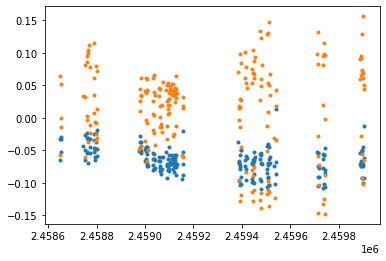

In [3]:
plt.plot(times, eigen2vectors[0], '.')
plt.plot(times, eigen2vectors[1], '.')
plt.show()

## Periodograms
### 1st component

Peak frequency = 
4188.511057387417


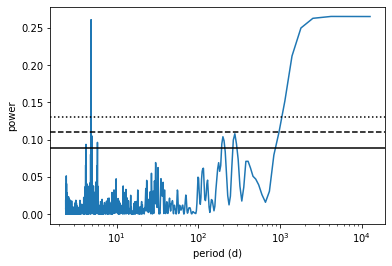

In [4]:
frequency, power = LombScargle(times, eigen2vectors[0]).autopower()
plt.figure(2)
plt.plot(1/frequency, power)
plt.xlabel("period (d)")
plt.ylabel("power")
plt.xscale('log')


peak_freq = 1 / frequency[np.argmax(power)]
print('Peak frequency = ')
print(peak_freq)

ls = LombScargle(times, eigen2vectors[0])

fap = ls.false_alarm_level(0.1)
plt.axhline(fap, linestyle='-', color='k')

fap = ls.false_alarm_level(0.01)
plt.axhline(fap, linestyle='--', color='k')

fap = ls.false_alarm_level(0.001)
plt.axhline(fap, linestyle=':', color='k')

plt.show()

### 2nd component

Peak frequency = 
4.872250163692226


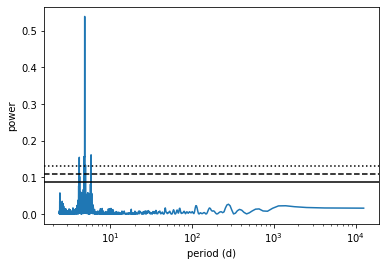

In [5]:
frequency, power = LombScargle(times, eigen2vectors[1]).autopower()
plt.figure(2)
plt.plot(1/frequency, power)
plt.xlabel("period (d)")
plt.ylabel("power")
plt.xscale('log')


peak_freq = 1 / frequency[np.argmax(power)]
print('Peak frequency = ')
print(peak_freq)

ls = LombScargle(times, eigen2vectors[1])

fap = ls.false_alarm_level(0.1)
plt.axhline(fap, linestyle='-', color='k')

fap = ls.false_alarm_level(0.01)
plt.axhline(fap, linestyle='--', color='k')

fap = ls.false_alarm_level(0.001)
plt.axhline(fap, linestyle=':', color='k')

plt.show()

## First component GP 

In [16]:
print(2*(np.max(eigen2vectors[0])- np.min(eigen2vectors[0])))
print(np.std(eigen2vectors[0]))
print(10*(np.max(times)-np.min(times)))


0.24633063548006165
0.020687797217148286
12565.53317216225


In [17]:
#Priors
n_eta1 = ModifiedLogUniform(0.02, 0.25)
n_eta2 = stats.loguniform(1, 12565)
n_eta3 = stats.norm(loc=4.865, scale=0.1)
n_eta4 = stats.loguniform(0.1, 5)
jitter = ModifiedLogUniform(0.02, 0.25)

In [18]:
def priors():
    return np.array([n_eta1.rvs(),n_eta2.rvs(), n_eta3.rvs(), n_eta4.rvs(), jitter.rvs()])

In [19]:
def logPosterior(HyperParam):
    n1,n2,n3,n4, j = HyperParam
    
    logprior = n_eta1.logpdf(n1)
    logprior += n_eta2.logpdf(n2)
    logprior += n_eta3.logpdf(n3)
    logprior += n_eta4.logpdf(n4)
    logprior += jitter.logpdf(j)
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(eigen2vectors[0]))
    gpOBJ = process.GP(kernel,mean,times,eigen2vectors[0], yerr = 1e-12 * np.identity(times.size))
    
    logposterior = gpOBJ.log_likelihood() + logprior
    return logposterior

In [20]:
ndim = priors().size 
nwalkers = 2*ndim

In [21]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)
p0=[priors() for i in range(nwalkers)]
sampler.run_mcmc(p0, 10000, progress=True)

100%|██████████| 10000/10000 [07:03<00:00, 23.64it/s]


State([[1.98397909e-02 9.56931376e+01 4.86355178e+00 1.01822085e+00
  7.18021640e-03]
 [2.21556533e-02 9.72796486e+01 4.86269241e+00 9.85165843e-01
  7.39691024e-03]
 [1.95180875e-02 9.97168101e+01 4.86180740e+00 8.56749862e-01
  7.36550115e-03]
 [2.26210151e-02 7.97468517e+01 4.85608172e+00 9.56841011e-01
  8.07575077e-03]
 [2.70285066e-02 9.81482951e+01 4.85689657e+00 9.80681035e-01
  6.73895527e-03]
 [2.37516505e-02 1.09242607e+02 4.86909944e+00 1.18722478e+00
  7.88308429e-03]
 [2.80378086e-02 9.84436529e+01 4.85728543e+00 1.34581097e+00
  8.86401357e-03]
 [2.38331526e-02 1.23639224e+02 4.86387225e+00 1.09780600e+00
  8.25733438e-03]
 [3.24847890e-02 1.30669374e+02 4.86987540e+00 1.26908715e+00
  7.36440244e-03]
 [2.32109311e-02 9.28051806e+01 4.85592179e+00 9.21209081e-01
  6.80932165e-03]], log_prob=[650.48707585 651.33630571 649.54456076 647.74831358 647.73105502
 651.41444872 646.45721483 650.57255415 649.48941061 648.32087606], blobs=None, random_state=('MT19937', array([17369

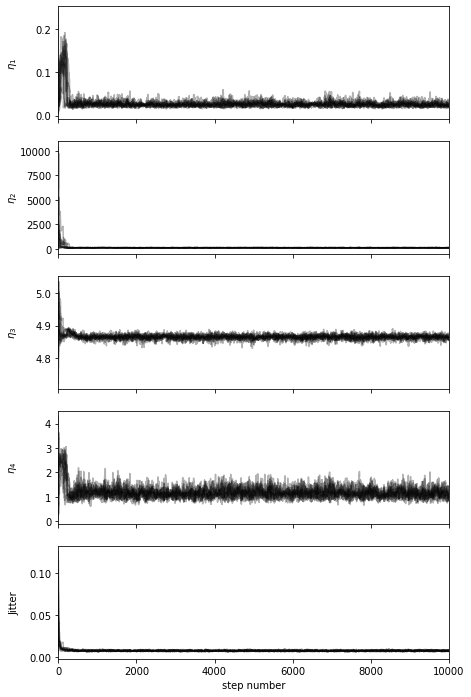

In [22]:
#chains plot
fig, axes = plt.subplots(5, figsize=(7, 12), sharex=True)
samples = sampler.get_chain()
labels = ["$\eta_1$", "$\eta_2$", "$\eta_3$", "$\eta_4$", "Jitter"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.show()

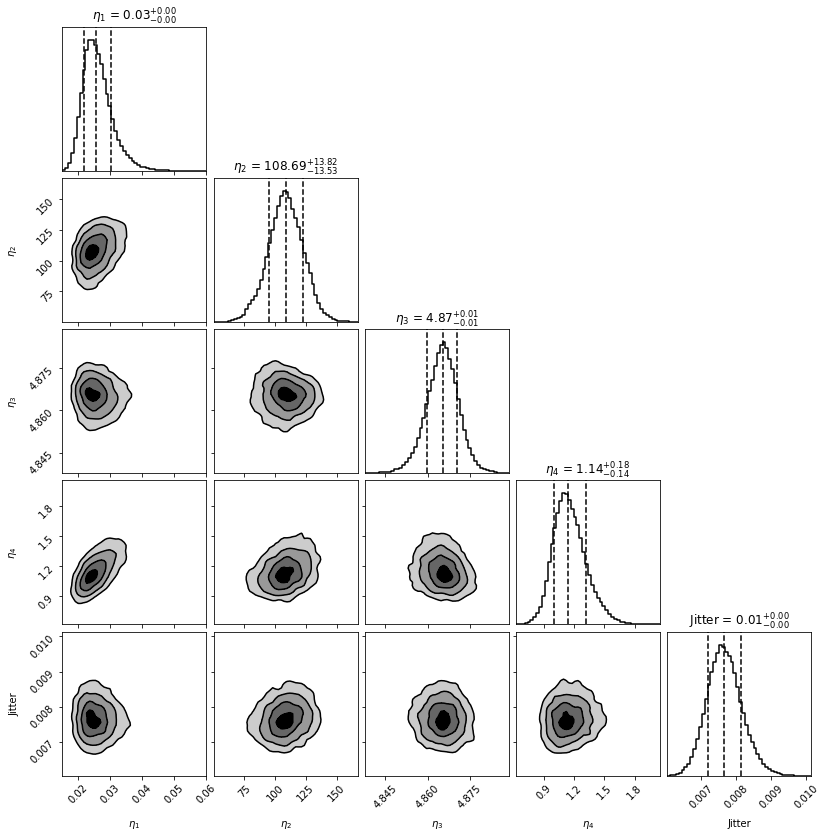

In [23]:
#corner plot
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
fig = corner.corner(flat_samples,labels=labels, color="k", bins = 50,
                    quantiles=[0.16, 0.5, 0.84], smooth=True, smooth1d=True, 
                    show_titles=True, plot_density=True, plot_contours=True,
                    fill_contours=True, plot_datapoints=False)
plt.show()

In [24]:
def Display(HyperParam, tplot):
    n1,n2,n3,n4, j = HyperParam
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(eigen2vectors[0]))
    gpOBJ = process.GP(kernel,mean,times,eigen2vectors[0],yerr = 1e-12 * np.identity(times.size))
    
    y_mean, y_std, time = gpOBJ.prediction(kernel,mean,tplot)
    return y_mean

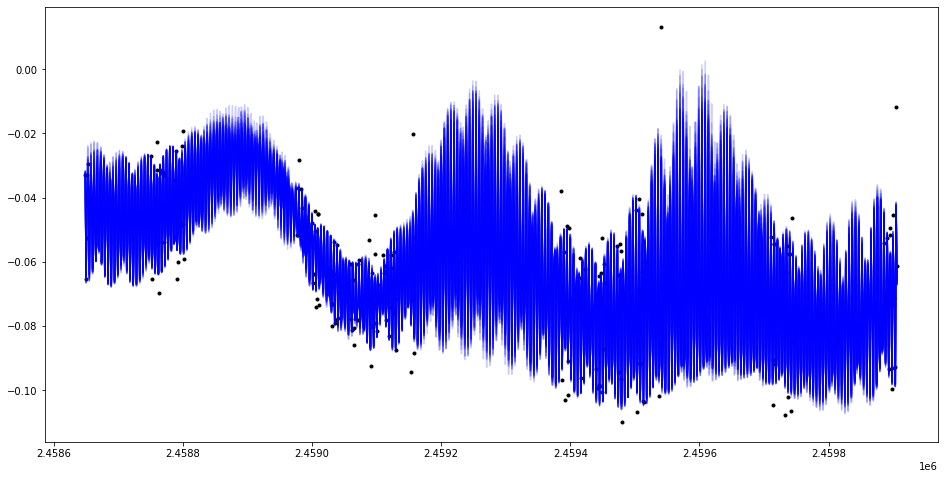

In [25]:
plt.figure(figsize=(16, 8))

plt.plot(times, eigen2vectors[0],'k.')
tplot = np.linspace(np.min(times), np.max(times), 1000)

for s in range(25):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.2)
plt.show()

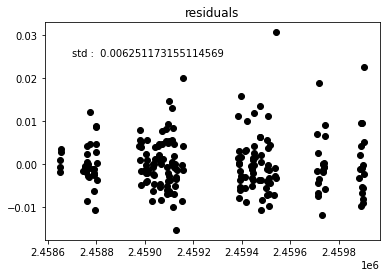

In [34]:
y_sample = Display(flat_samples[0,:], times)

residuals = eigen2vectors[0] - y_sample

plt.plot(times, residuals, 'ok')
plt.annotate( "std :  " + str(np.std(residuals)), (2.4587*1e6, 0.025) )
plt.title('residuals')
plt.show()

## 2nd component GP

In [130]:
print(2*(np.max(eigen2vectors[1])- np.min(eigen2vectors[1])))
print(np.std(eigen2vectors[1]))
print(10*(np.max(times)-np.min(times)))

0.6080053951959095
0.06720146635109973
12565.53317216225


In [131]:
#Priors
n_eta1 = ModifiedLogUniform(0.06, 0.6)
n_eta2 = stats.loguniform(1, 12565)
n_eta3 = stats.norm(loc=4.865, scale=0.1)
n_eta4 = stats.loguniform(0.1, 5)
jitter = ModifiedLogUniform(0.06, 0.6)

In [132]:
def priors():
    return np.array([n_eta1.rvs(),n_eta2.rvs(), n_eta3.rvs(), n_eta4.rvs(), jitter.rvs()])

In [133]:
def logPosterior(HyperParam):
    n1,n2,n3,n4, j = HyperParam
    
    logprior = n_eta1.logpdf(n1)
    logprior += n_eta2.logpdf(n2)
    logprior += n_eta3.logpdf(n3)
    logprior += n_eta4.logpdf(n4)
    logprior += jitter.logpdf(j)
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(eigen2vectors[1]))
    gpOBJ = process.GP(kernel,mean,times,eigen2vectors[1], yerr = 1e-12 * np.identity(times.size))
    
    logposterior = gpOBJ.log_likelihood() + logprior
    return logposterior

In [134]:
ndim = priors().size 
nwalkers = 2*ndim

In [135]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)
p0=[priors() for i in range(nwalkers)]
sampler.run_mcmc(p0, 10000, progress=True)

100%|██████████| 10000/10000 [08:51<00:00, 18.82it/s]


State([[7.22240979e-02 9.65040434e+01 4.86590586e+00 1.09166999e+00
  1.28098678e-02]
 [6.45240305e-02 1.08508244e+02 4.86290624e+00 1.00633929e+00
  1.50701547e-02]
 [5.91831669e-02 1.09330493e+02 4.86945396e+00 7.24631403e-01
  1.29445018e-02]
 [5.40081363e-02 1.19028806e+02 4.86941561e+00 6.83612847e-01
  1.36494739e-02]
 [6.68563101e-02 6.41760052e+01 4.85889771e+00 9.18512119e-01
  1.16010503e-02]
 [6.60655682e-02 1.20477961e+02 4.86650439e+00 8.05666415e-01
  1.48330126e-02]
 [8.23311244e-02 1.38312284e+02 4.85871499e+00 9.32933487e-01
  1.59303065e-02]
 [5.18589794e-02 1.90838885e+02 4.85955845e+00 6.39946178e-01
  1.48245931e-02]
 [6.76579031e-02 9.58825383e+01 4.86198405e+00 9.26346467e-01
  1.51699093e-02]
 [6.46410825e-02 1.07824696e+02 4.86565287e+00 9.66771456e-01
  1.46800152e-02]], log_prob=[493.56454919 494.24250163 493.73650499 492.13276053 491.42433117
 493.66963435 490.20322819 487.81173035 492.85190913 495.10947674], blobs=None, random_state=('MT19937', array([21946

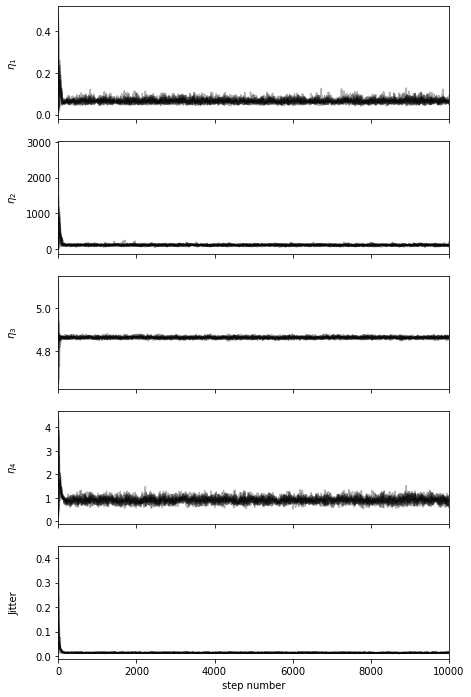

In [136]:
#chains plot
fig, axes = plt.subplots(5, figsize=(7, 12), sharex=True)
samples = sampler.get_chain()
labels = ["$\eta_1$", "$\eta_2$", "$\eta_3$", "$\eta_4$", "Jitter"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.show()

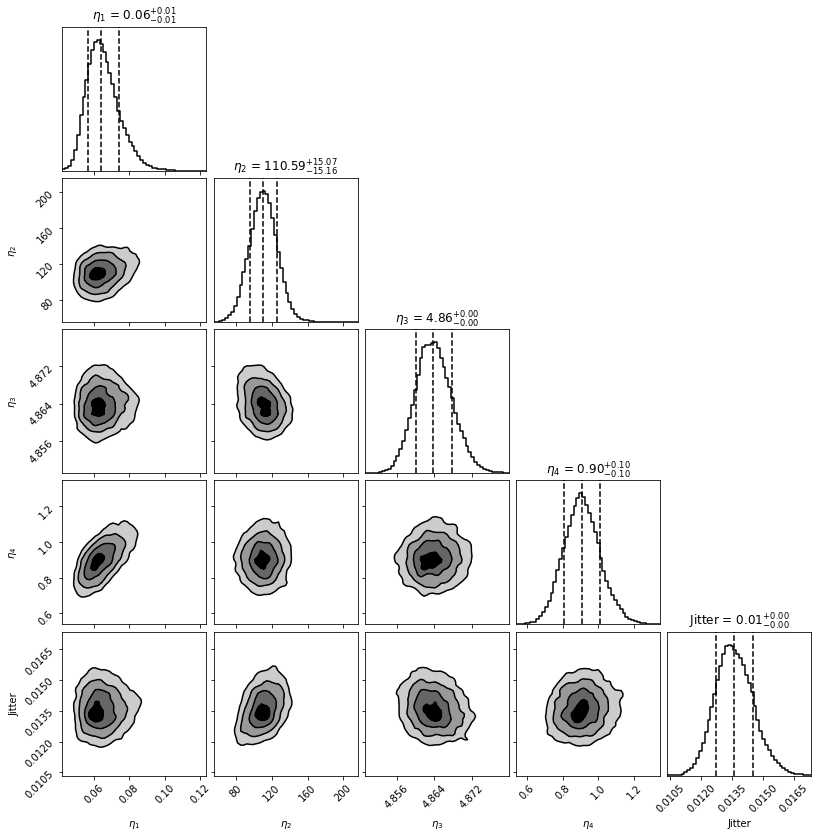

In [137]:
#corner plot
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
fig = corner.corner(flat_samples,labels=labels, color="k", bins = 50,
                    quantiles=[0.16, 0.5, 0.84], smooth=True, smooth1d=True, 
                    show_titles=True, plot_density=True, plot_contours=True,
                    fill_contours=True, plot_datapoints=False)
plt.show()

In [138]:
def Display(HyperParam, tplot):
    n1,n2,n3,n4, j = HyperParam
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(eigen2vectors[1]))
    gpOBJ = process.GP(kernel,mean,times,eigen2vectors[1],yerr = 1e-12 * np.identity(times.size))
    
    y_mean, y_std, time = gpOBJ.prediction(kernel,mean,tplot)
    return y_mean

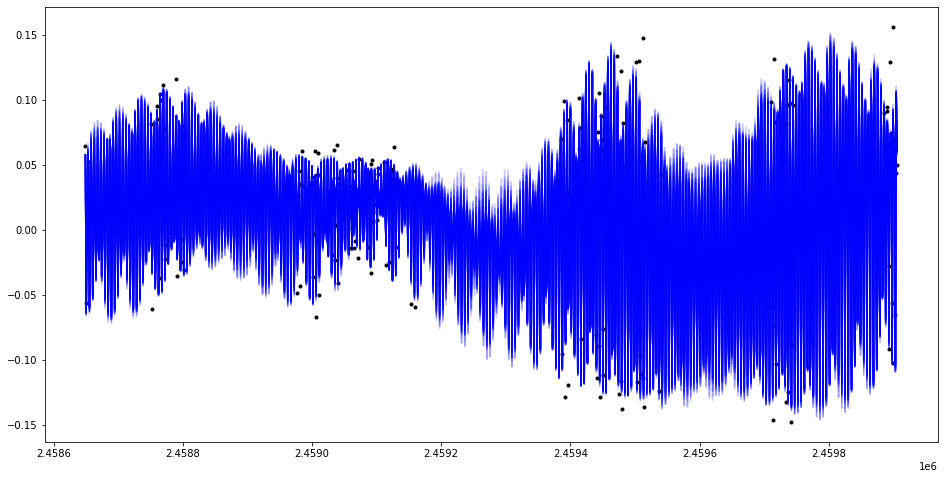

In [139]:
plt.figure(figsize=(16, 8))

plt.plot(times, eigen2vectors[1],'k.')
tplot = np.linspace(np.min(times), np.max(times), 1000)
 
for s in range(25):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.2)
plt.show()

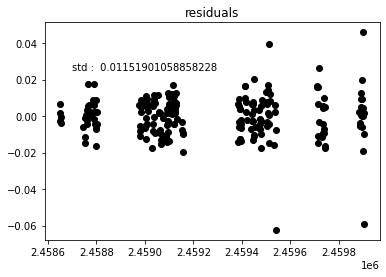

In [140]:
y_sample = Display(flat_samples[0,:], times)

residuals = eigen2vectors[1] - y_sample

plt.plot(times, residuals, 'ok')
plt.annotate( "std :  " + str(np.std(residuals)), (2.4587*1e6, 0.025) )
plt.title('residuals')
plt.show()